In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('cleaned_bank_data.csv')

In [8]:
df.columns

Index(['Customer ID', 'full_name', 'Age', 'Gender', 'City', 'Account_Type',
       'Account_Balance', 'Date_Of_Account_Opening', 'Last_Transaction_Date',
       'Transaction_Amount', 'Loan_Status', 'Credit_Limit',
       'Credit_Card_Balance', 'Last_Credit_Card_Payment_Date',
       'Rewards_Points'],
      dtype='object')

In [9]:
df.describe()

Customer ID          Age  Account_Balance  Transaction_Amount  \
count  5000.000000  5000.000000      5000.000000         5000.000000   
mean   2500.500000    43.469800      5060.570918         2508.501144   
std    1443.520003    15.145672      2849.356481         1450.194986   
min       1.000000    18.000000       107.200000           10.570000   
25%    1250.750000    30.000000      2582.777500         1241.150000   
50%    2500.500000    43.000000      5075.500000         2494.025000   
75%    3750.250000    57.000000      7509.760000         3796.222500   
max    5000.000000    69.000000      9998.110000         4998.390000   

       Credit_Limit  Credit_Card_Balance  Rewards_Points  
count   5000.000000           5000.00000     5000.000000  
mean    5549.035830           2487.40084     4966.161800  
std     2581.718105           1446.80295     2901.410915  
min     1007.000000              1.45000        1.000000  
25%     3314.065000           1243.51750     2475.250000  
50%     5567.485000           2461.62000     4950.500000  
75%     7786.040000           3722.58000     7483.250000  
max     9997.780000           4997.11000     9999.000000

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer ID                    5000 non-null   int64  
 1   full_name                      5000 non-null   object 
 2   Age                            5000 non-null   int64  
 3   Gender                         5000 non-null   object 
 4   City                           5000 non-null   object 
 5   Account_Type                   5000 non-null   object 
 6   Account_Balance                5000 non-null   float64
 7   Date_Of_Account_Opening        5000 non-null   object 
 8   Last_Transaction_Date          5000 non-null   object 
 9   Transaction_Amount             5000 non-null   float64
 10  Loan_Status                    5000 non-null   object 
 11  Credit_Limit                   5000 non-null   float64
 12  Credit_Card_Balance            5000 non-null   f

In [18]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
from fcmeans import FCM
from sklearn.cluster import BisectingKMeans

In [22]:
date_cols = ['Date_Of_Account_Opening', 'Last_Transaction_Date', 'Last_Credit_Card_Payment_Date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Compute days since account opening to last transaction

df['Account_Age_Days'] = (df['Last_Transaction_Date'] - df['Date_Of_Account_Opening']).dt.days

df_clean = df.drop(['Customer ID', 'full_name', 'City', 'Date_Of_Account_Opening','Last_Transaction_Date', 'Last_Credit_Card_Payment_Date'], axis=1)

df_encoded = pd.get_dummies(df_clean, columns=['Gender', 'Account_Type', 'Loan_Status'], drop_first=True)

df_encoded = df_encoded.fillna(df_encoded.median())

features = ['Age', 'Account_Balance', 'Transaction_Amount', 'Credit_Limit','Credit_Card_Balance', 'Rewards_Points', 'Account_Age_Days'] + \
[col for col in df_encoded.columns if col.startswith('Gender_') or col.startswith('Account_Type_') or col.startswith('Loan_Status_')]

X = df_encoded[features]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [23]:
X_scaled

array([[ 0.10104227, -1.31523231, -0.72472754, ..., -1.00280393,
        -0.70498652,  1.43787505],
       [ 0.23310641,  0.32568122, -0.58447031, ..., -1.00280393,
        -0.70498652, -0.69547072],
       [-1.21959909,  1.12924826, -1.15071287, ..., -1.00280393,
         1.41846685, -0.69547072],
       ...,
       [ 0.10104227, -0.81704194, -1.44141319, ..., -1.00280393,
        -0.70498652,  1.43787505],
       [ 0.95945916, -0.7211335 ,  0.44995612, ..., -1.00280393,
        -0.70498652,  1.43787505],
       [-0.55927841,  0.68879249, -1.53591339, ..., -1.00280393,
        -0.70498652,  1.43787505]])

In [29]:
n_clusters = 9
random_state = 42


In [30]:
# 1. K-means++ (already implemented in sklearn's KMeans with init='k-means++')
kmeans_plus = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
kmeans_plus_labels = kmeans_plus.fit_predict(X_scaled)

# 2. Mini-batch K-means
minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, batch_size=256)
minibatch_labels = minibatch_kmeans.fit_predict(X_scaled)

# 3. Bisecting K-means
bisecting_kmeans = BisectingKMeans(n_clusters=n_clusters, random_state=random_state)
bisecting_labels = bisecting_kmeans.fit_predict(X_scaled)

# 4. Fuzzy C-means
fcm = FCM(n_clusters=n_clusters, random_state=random_state)
fcm.fit(X_scaled)
fcm_labels = fcm.predict(X_scaled)

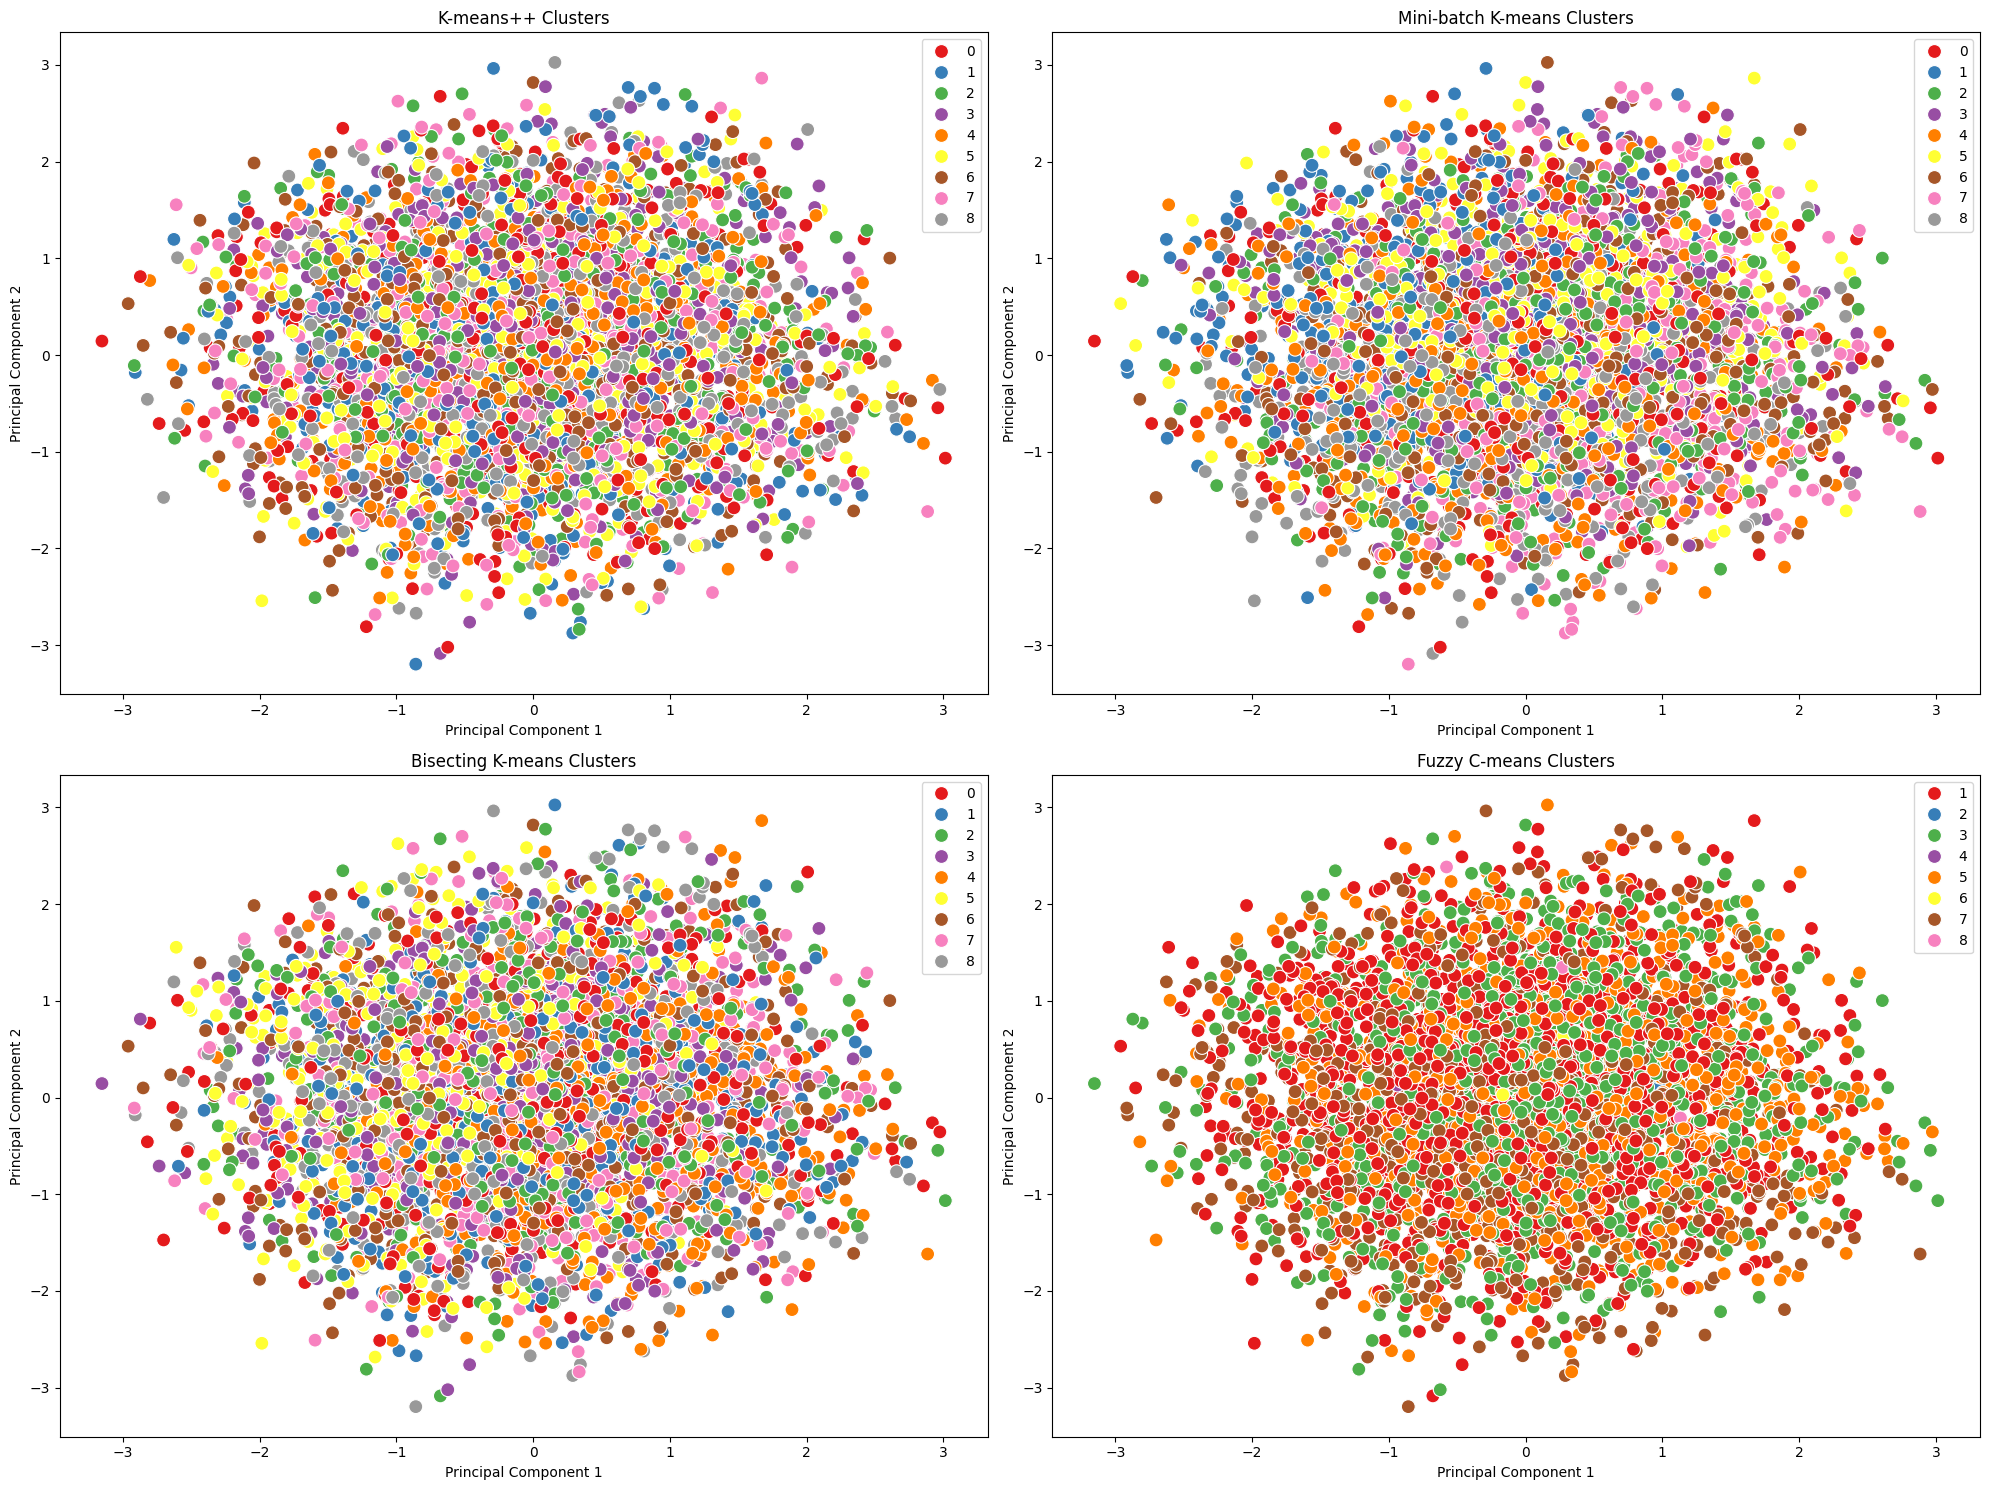

In [31]:
# Create visualization
plt.figure(figsize=(20, 15))

# Plot K-means++
plt.subplot(2, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_plus_labels, palette='Set1', s=100)
plt.title("K-means++ Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot Mini-batch K-means
plt.subplot(2, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=minibatch_labels, palette='Set1', s=100)
plt.title("Mini-batch K-means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot Bisecting K-means
plt.subplot(2, 2, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=bisecting_labels, palette='Set1', s=100)
plt.title("Bisecting K-means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot Fuzzy C-means
plt.subplot(2, 2, 4)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=fcm_labels, palette='Set1', s=100)
plt.title("Fuzzy C-means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


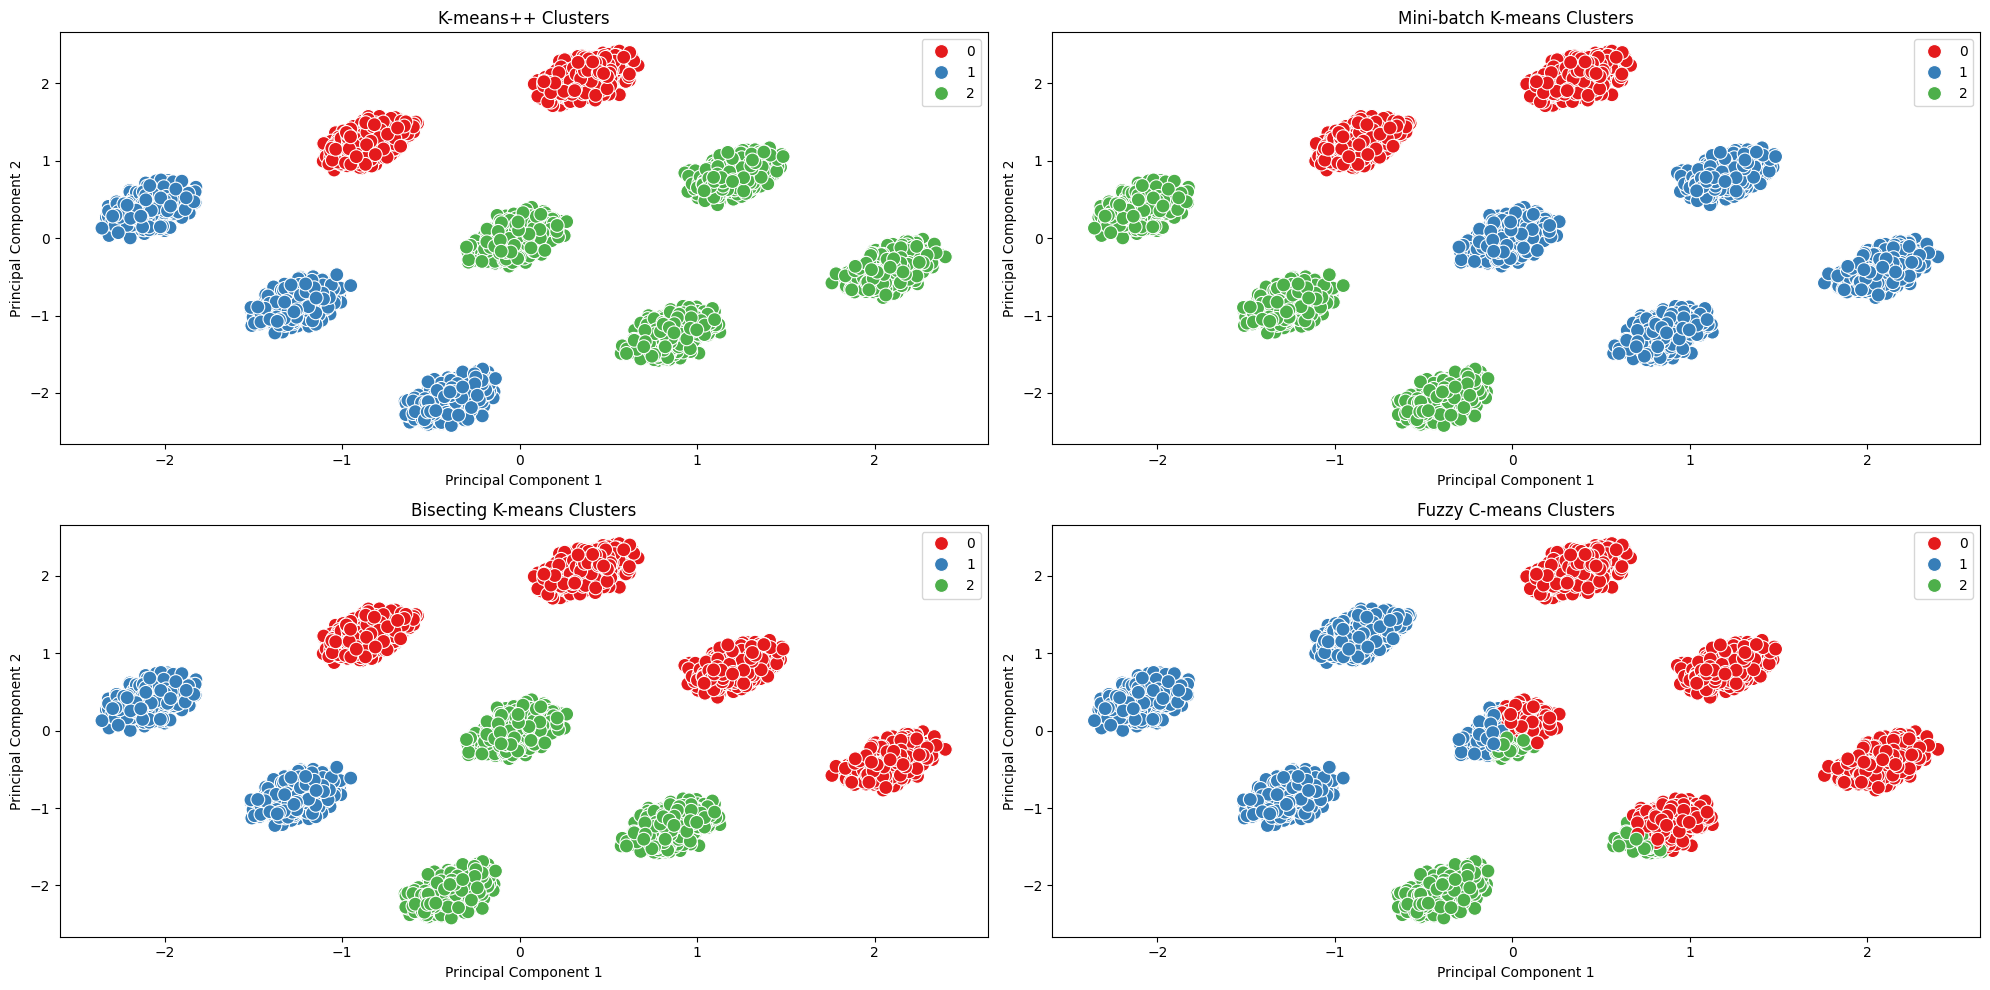

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from fcmeans import FCM

# Reduce data to 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Initialize clustering algorithms
best_k = 3
random_state = 42

# Create subplots
plt.figure(figsize=(20, 10))

# 1. K-means++
kmeans_plus = KMeans(n_clusters=best_k, init='k-means++', random_state=random_state)
kmeans_plus_labels = kmeans_plus.fit_predict(X_scaled)

plt.subplot(2, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_plus_labels, palette='Set1', s=100)
plt.title("K-means++ Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# 2. Mini-batch K-means
minibatch = MiniBatchKMeans(n_clusters=best_k, random_state=random_state, batch_size=256)
minibatch_labels = minibatch.fit_predict(X_scaled)

plt.subplot(2, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=minibatch_labels, palette='Set1', s=100)
plt.title("Mini-batch K-means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# 3. Bisecting K-means
bisecting = BisectingKMeans(n_clusters=best_k, random_state=random_state)
bisecting_labels = bisecting.fit_predict(X_scaled)

plt.subplot(2, 2, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=bisecting_labels, palette='Set1', s=100)
plt.title("Bisecting K-means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# 4. Fuzzy C-means
fcm = FCM(n_clusters=best_k, random_state=random_state)
fcm.fit(X_scaled)
fcm_labels = fcm.predict(X_scaled)

plt.subplot(2, 2, 4)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=fcm_labels, palette='Set1', s=100)
plt.title("Fuzzy C-means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

In [32]:
# Calculate clustering metrics
algorithms = {
    'K-means++': kmeans_plus_labels,
    'Mini-batch K-means': minibatch_labels,
    'Bisecting K-means': bisecting_labels,
    'Fuzzy C-means': fcm_labels
}

metrics = {}
for name, labels in algorithms.items():
    metrics[name] = {
        'Silhouette Score': silhouette_score(X_scaled, labels),
        'Calinski-Harabasz Score': calinski_harabasz_score(X_scaled, labels),
        'Davies-Bouldin Score': davies_bouldin_score(X_scaled, labels)
    }

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics).round(3)
print("\nClustering Performance Metrics:")
print(metrics_df)

# Analyze cluster characteristics
for name, labels in algorithms.items():
    print(f"\n{name} Cluster Characteristics:")
    df_encoded['Cluster'] = labels
    cluster_stats = df_encoded.groupby('Cluster')[features].mean()
    print(cluster_stats.round(2))


Clustering Performance Metrics:
                         K-means++  Mini-batch K-means  Bisecting K-means  \
Silhouette Score             0.122               0.091              0.100   
Calinski-Harabasz Score    313.560             275.176            291.227   
Davies-Bouldin Score         2.623               2.792              2.950   

                         Fuzzy C-means  
Silhouette Score                -0.055  
Calinski-Harabasz Score        172.054  
Davies-Bouldin Score             2.169  

K-means++ Cluster Characteristics:
           Age  Account_Balance  Transaction_Amount  Credit_Limit  \
Cluster                                                             
0        44.31          5197.41             2441.44       5589.00   
1        41.61          4992.24             2494.74       5364.08   
2        42.36          5116.09             2696.55       5574.19   
3        44.02          5018.77             2616.86       5416.96   
4        44.73          4958.64             

c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Clustering Performance Metrics:
--------------------------------------------------

HDBSCAN:
Silhouette Score: 0.137
Calinski-Harabasz Score: 190.457
Davies-Bouldin Score: 2.440

OPTICS:
Silhouette Score: 0.603
Calinski-Harabasz Score: 54.832
Davies-Bouldin Score: 0.579

DBSCAN++:
Silhouette Score: 0.132
Calinski-Harabasz Score: 199.413
Davies-Bouldin Score: 2.504


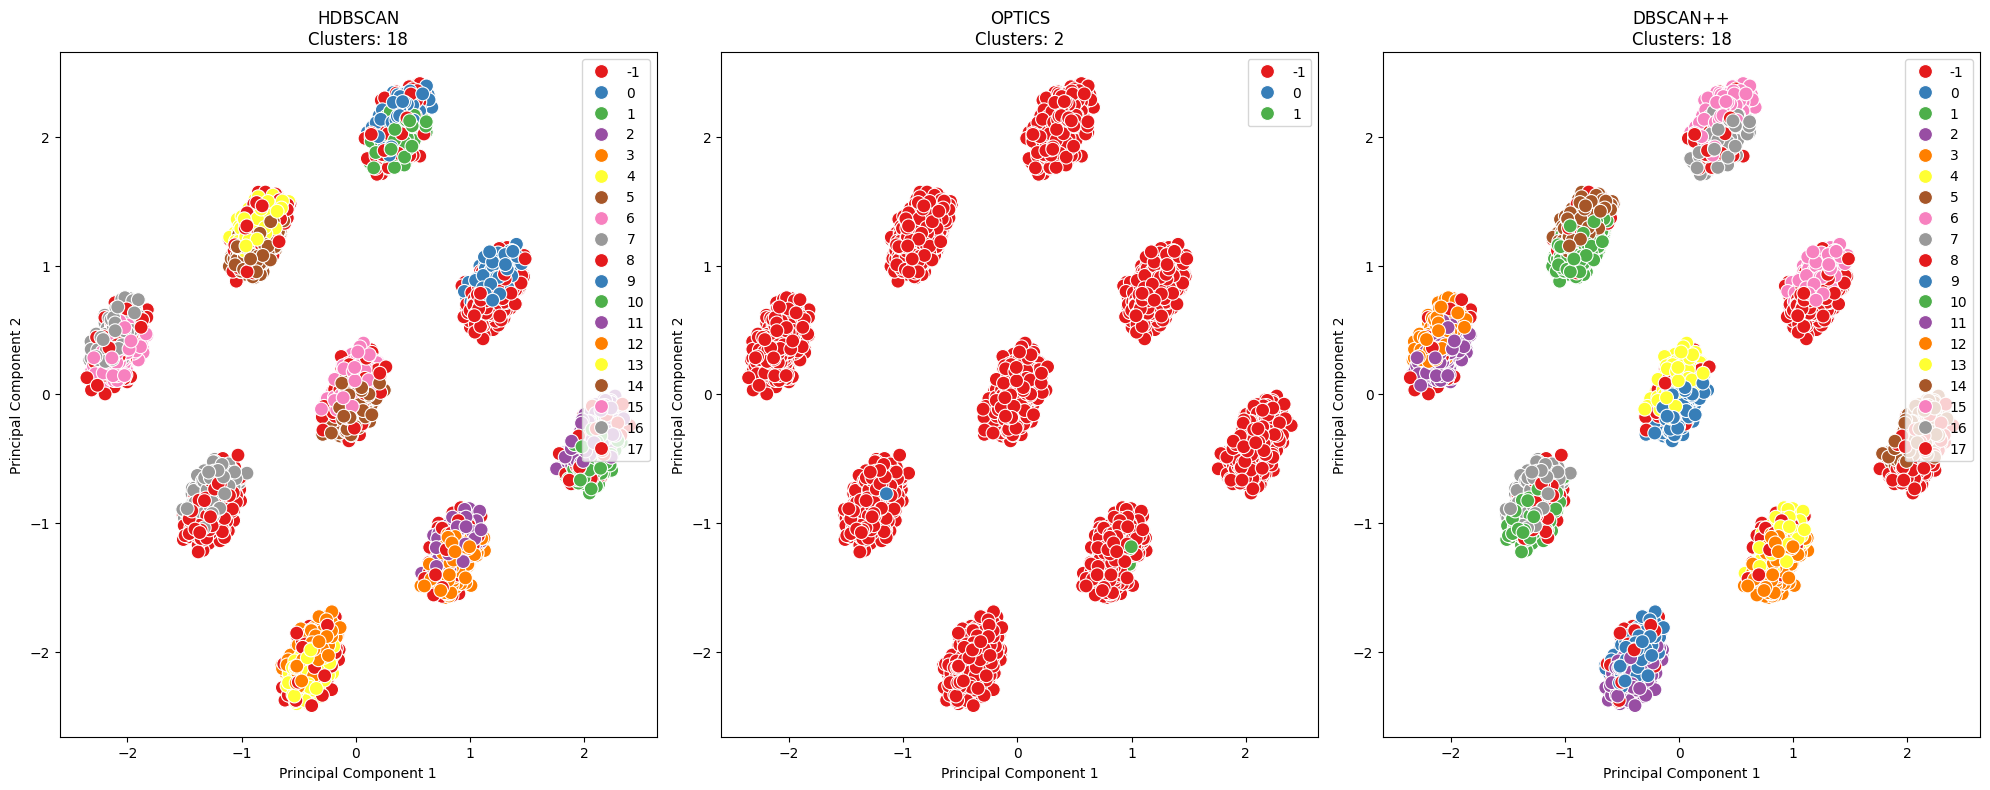

In [36]:
# Import required libraries
import hdbscan
from sklearn.cluster import OPTICS, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplot grid
plt.figure(figsize=(20, 15))

# 1. HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
hdbscan_labels = clusterer.fit_predict(X_scaled)

plt.subplot(2, 3, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hdbscan_labels, palette='Set1', s=100)
plt.title(f"HDBSCAN\nClusters: {len(np.unique(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# 2. OPTICS
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=10)
optics_labels = optics.fit_predict(X_scaled)

plt.subplot(2, 3, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=optics_labels, palette='Set1', s=100)
plt.title(f"OPTICS\nClusters: {len(np.unique(optics_labels)) - (1 if -1 in optics_labels else 0)}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# 3. DBSCAN++ (Modified DBSCAN with improved seeding)
def dbscan_plus_plus(X, eps=2, min_samples=10, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    
    # Select initial center randomly
    centers = [np.random.randint(n_samples)]
    distances = np.full(n_samples, np.inf)
    
    # Select remaining centers
    while len(centers) < min_samples:
        dist = np.linalg.norm(X - X[centers[-1]], axis=1)
        distances = np.minimum(distances, dist)
        next_center = np.argmax(distances)
        centers.append(next_center)
    
    # Run DBSCAN with selected centers
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(X)

dbscan_pp_labels = dbscan_plus_plus(X_scaled)

plt.subplot(2, 3, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_pp_labels, palette='Set1', s=100)
plt.title(f"DBSCAN++\nClusters: {len(np.unique(dbscan_pp_labels)) - (1 if -1 in dbscan_pp_labels else 0)}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Calculate and display metrics
algorithms = {
    'HDBSCAN': hdbscan_labels,
    'OPTICS': optics_labels,
    'DBSCAN++': dbscan_pp_labels
}

print("\nClustering Performance Metrics:")
print("-" * 50)
for name, labels in algorithms.items():
    valid_points = labels != -1
    if sum(valid_points) > 1:
        X_valid = X_scaled[valid_points]
        labels_valid = labels[valid_points]
        
        if len(set(labels_valid)) > 1:
            print(f"\n{name}:")
            print(f"Silhouette Score: {silhouette_score(X_valid, labels_valid):.3f}")
            print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_valid, labels_valid):.3f}")
            print(f"Davies-Bouldin Score: {davies_bouldin_score(X_valid, labels_valid):.3f}")

plt.tight_layout()
plt.show()

c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all

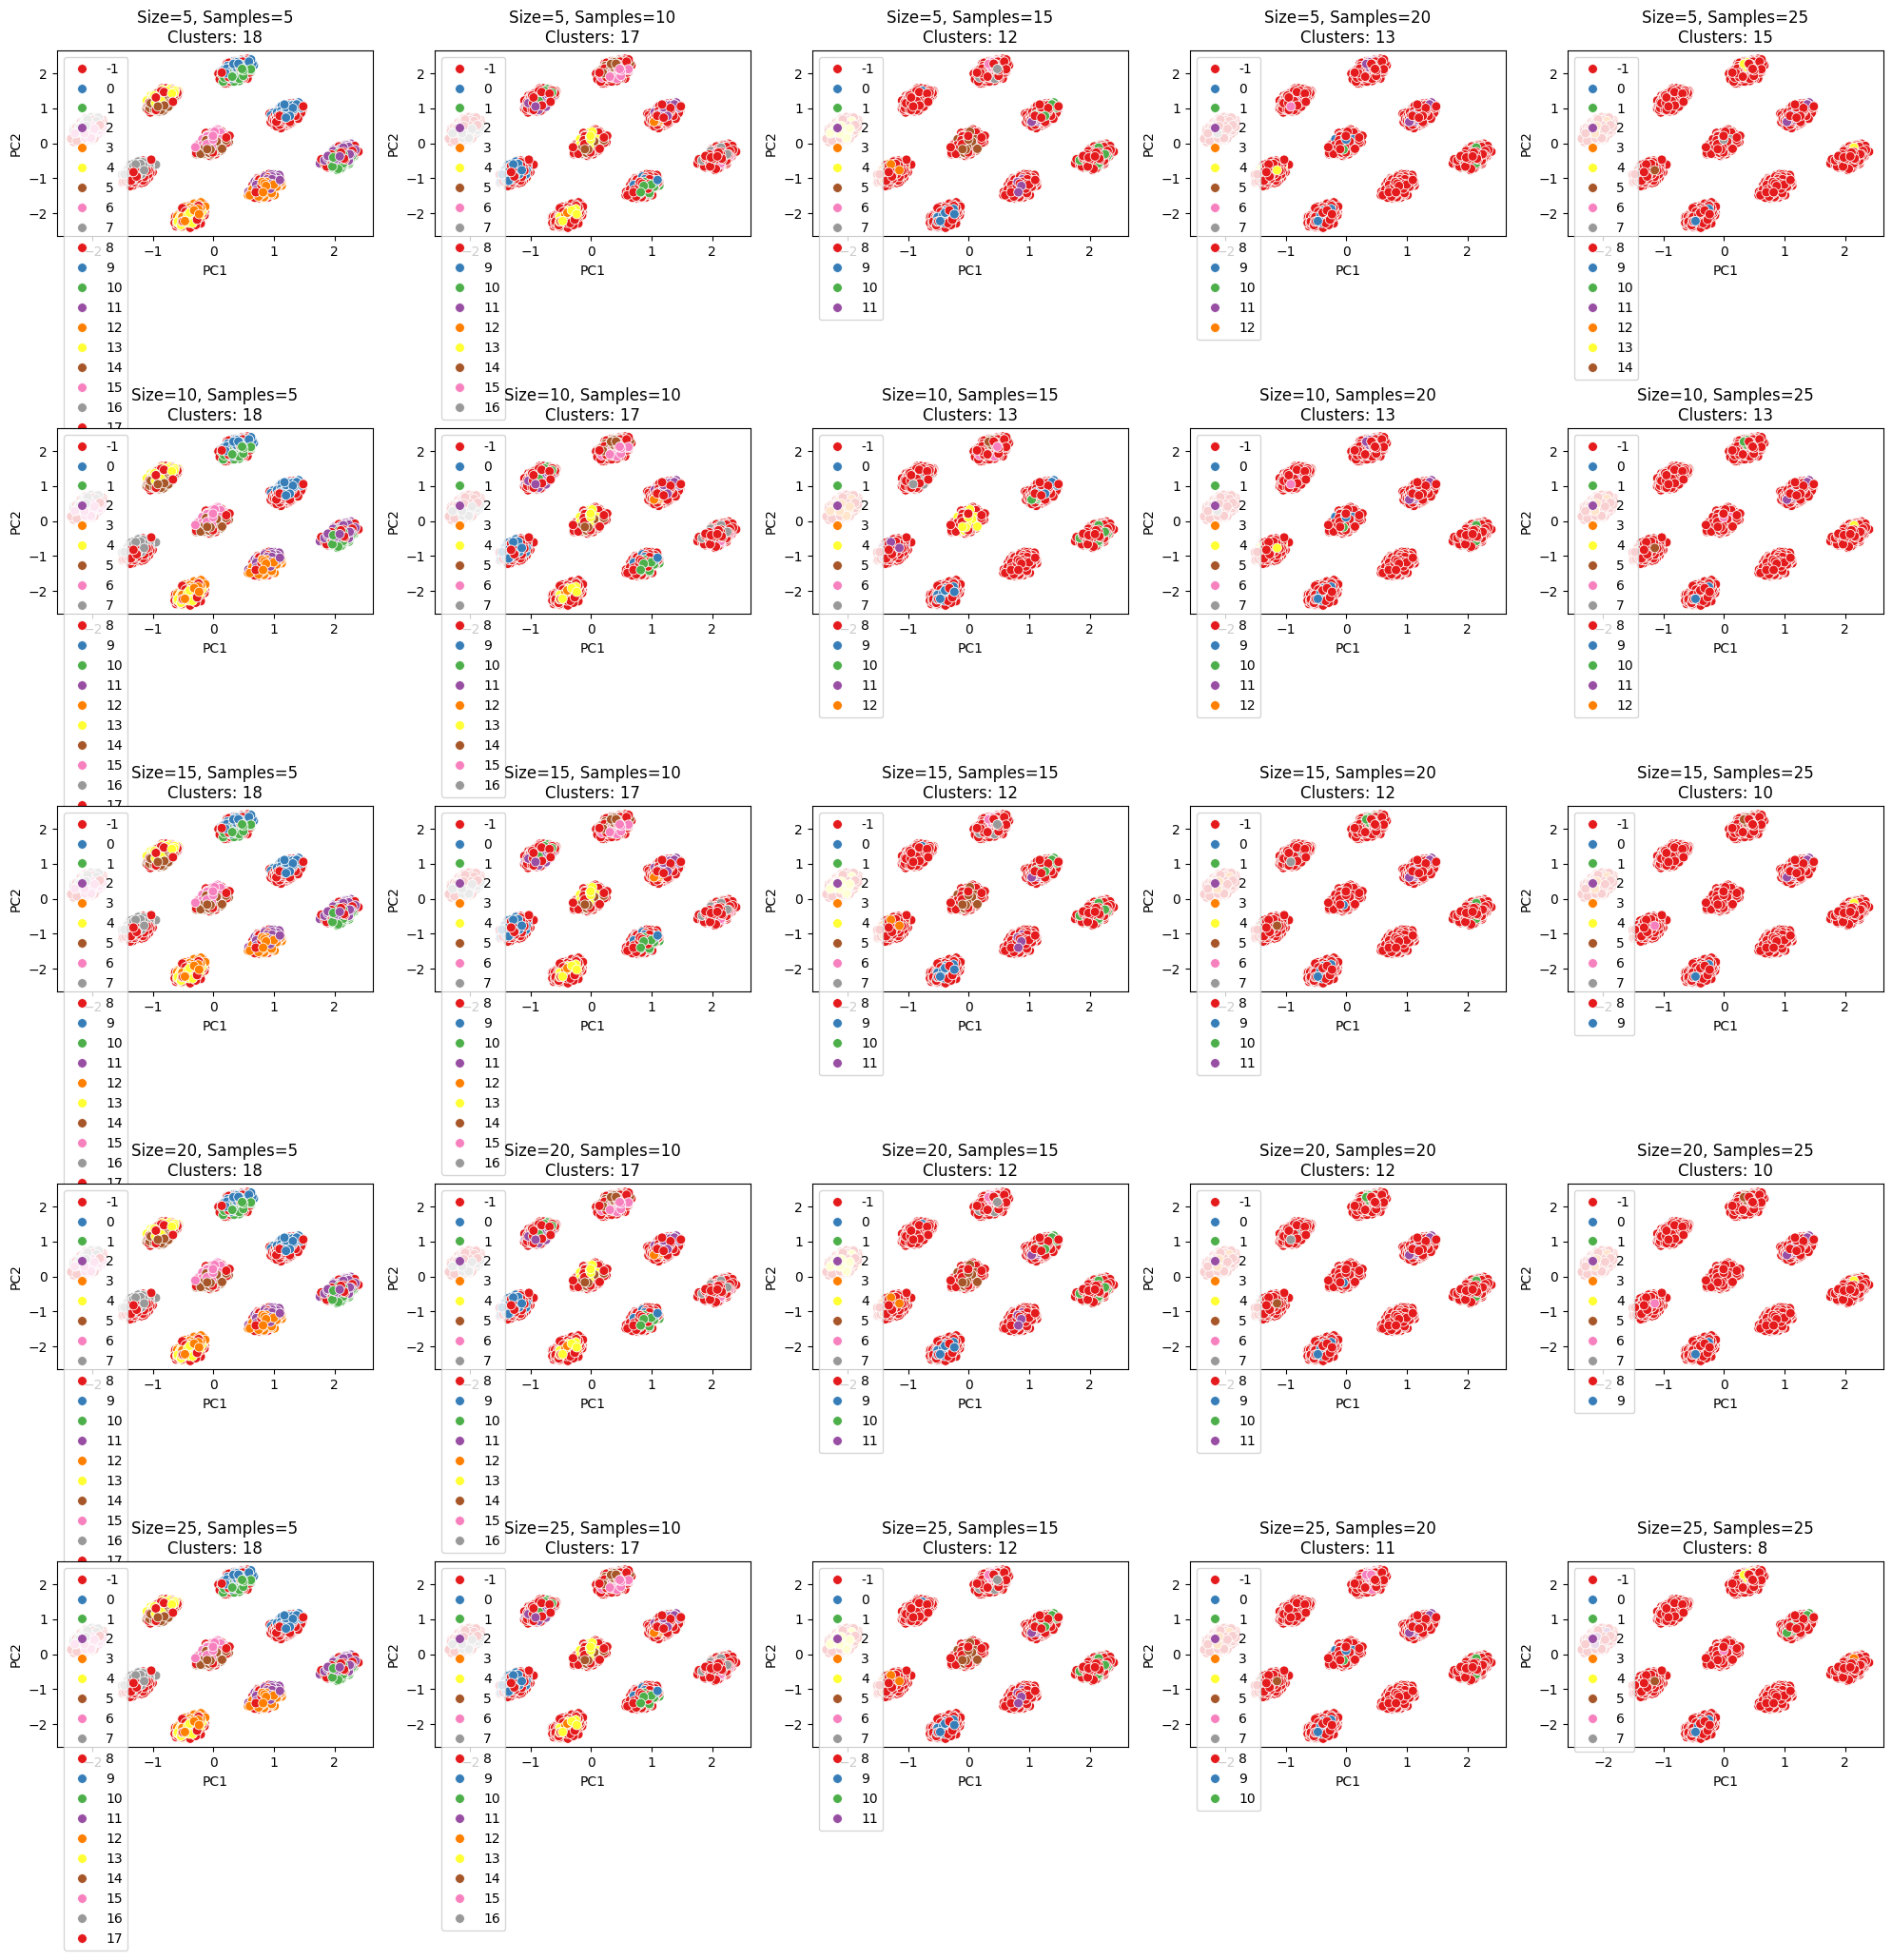


Parameter Search Results:
    min_cluster_size  min_samples  silhouette   calinski    davies  \
4                  5           25    0.166433  47.642825  1.640629   
24                25           25    0.164024  79.066375  1.913939   
3                  5           20    0.162464  83.185406  1.869212   
8                 10           20    0.162464  83.185406  1.869212   
9                 10           25    0.159943  55.259769  1.727196   

    n_clusters  noise_points  
4           15          4451  
24           8          4313  
3           13          3992  
8           13          3992  
9           13          4405  


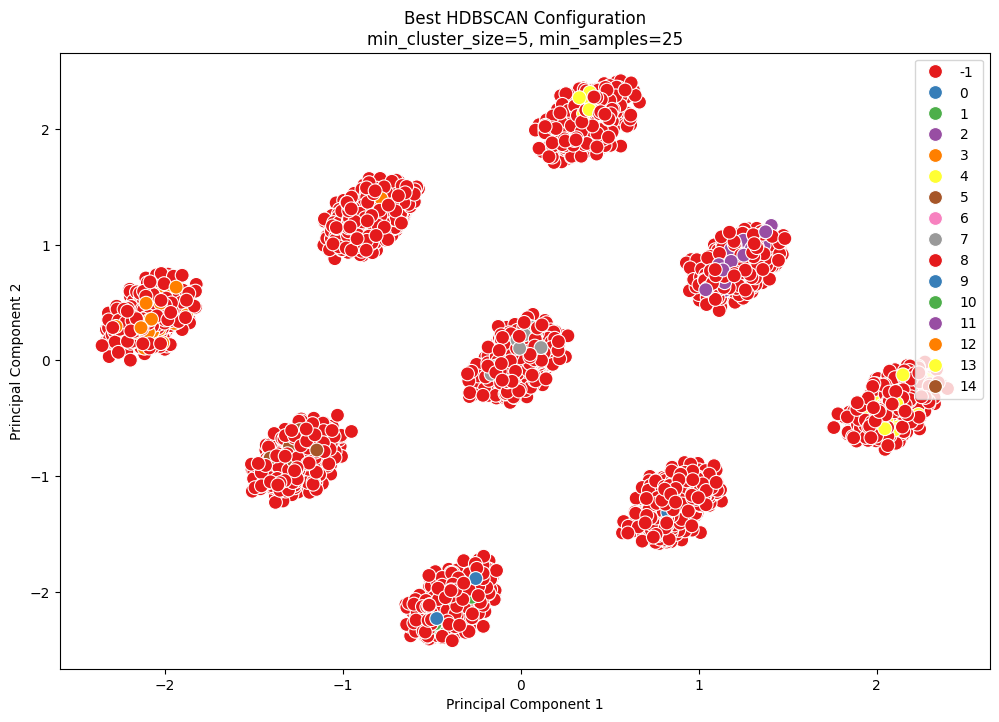


Best Configuration Metrics:
Parameters: min_cluster_size=5, min_samples=25
Number of clusters: 15.0
Noise points: 4451.0
Silhouette Score: 0.166
Calinski-Harabasz Score: 47.643
Davies-Bouldin Score: 1.641


In [37]:
# Test different combinations of parameters
min_cluster_sizes = [5, 10, 15, 20, 25]
min_samples_range = [5, 10, 15, 20, 25]

best_score = -1
best_params = None
best_labels = None
results = []

# Create figure for all combinations
plt.figure(figsize=(20, 20))
plot_idx = 1

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_range:
        # Fit HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples
        )
        labels = clusterer.fit_predict(X_scaled)
        
        # Calculate metrics if valid clustering exists
        valid_points = labels != -1
        if sum(valid_points) > 1 and len(set(labels)) > 1:
            X_valid = X_scaled[valid_points]
            labels_valid = labels[valid_points]
            
            if len(set(labels_valid)) > 1:
                silhouette = silhouette_score(X_valid, labels_valid)
                calinski = calinski_harabasz_score(X_valid, labels_valid)
                davies = davies_bouldin_score(X_valid, labels_valid)
                
                results.append({
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples,
                    'silhouette': silhouette,
                    'calinski': calinski,
                    'davies': davies,
                    'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                    'noise_points': list(labels).count(-1)
                })
                
                # Track best parameters based on silhouette score
                if silhouette > best_score:
                    best_score = silhouette
                    best_params = (min_cluster_size, min_samples)
                    best_labels = labels
        
        # Plot each combination
        plt.subplot(len(min_cluster_sizes), len(min_samples_range), plot_idx)
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=50)
        plt.title(f'Size={min_cluster_size}, Samples={min_samples}\nClusters: {len(set(labels)) - (1 if -1 in labels else 0)}')
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plot_idx += 1

plt.tight_layout()
plt.show()

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nParameter Search Results:")
print(results_df.sort_values('silhouette', ascending=False).head())

# Plot best configuration separately
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=best_labels, palette='Set1', s=100)
plt.title(f'Best HDBSCAN Configuration\nmin_cluster_size={best_params[0]}, min_samples={best_params[1]}')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Print detailed metrics for best configuration
print("\nBest Configuration Metrics:")
print(f"Parameters: min_cluster_size={best_params[0]}, min_samples={best_params[1]}")
best_result = results_df.loc[results_df['silhouette'].idxmax()]
print(f"Number of clusters: {best_result['n_clusters']}")
print(f"Noise points: {best_result['noise_points']}")
print(f"Silhouette Score: {best_result['silhouette']:.3f}")
print(f"Calinski-Harabasz Score: {best_result['calinski']:.3f}")
print(f"Davies-Bouldin Score: {best_result['davies']:.3f}")

Davies-Bouldin Score:

- It's a metric for evaluating clustering algorithms
- Lower values indicate better clustering
- It measures the average similarity between each cluster and its most similar cluster
- Helps evaluate how well-separated the clusters are
- Range: Values ≥ 0, where 0 is the best possible score
For your banking customer data, a low Davies-Bouldin score would indicate that:

- Customer segments are well-separated
- Each cluster represents a distinct group of customers
- Less overlap between different customer segments
Noise Points:

- Points that don't fit well into any cluster
- In your banking context, these could be:
  - High-net-worth individuals with unique banking patterns
  - Customers with unusual transaction behaviors
  - New customers with limited history
  - Accounts with very different balance patterns from the norm

c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\Documents\HP\old ssd\MY FILES\projects\New folder\clustering-algorithms\simple_ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Noise Points Analysis:
Total noise points: 4451
Percentage of noise points: 89.02%

Feature Comparison (Mean Values):

Age:
Noise points mean: 43.60
Regular points mean: 42.40
Difference: 2.84%

Account_Balance:
Noise points mean: 5053.31
Regular points mean: 5119.40
Difference: -1.29%

Transaction_Amount:
Noise points mean: 2508.26
Regular points mean: 2510.48
Difference: -0.09%

Credit_Limit:
Noise points mean: 5548.55
Regular points mean: 5552.97
Difference: -0.08%

Credit_Card_Balance:
Noise points mean: 2486.81
Regular points mean: 2492.16
Difference: -0.21%

Rewards_Points:
Noise points mean: 4959.90
Regular points mean: 5016.89
Difference: -1.14%

Account_Age_Days:
Noise points mean: 4407.64
Regular points mean: 4187.19
Difference: 5.26%

Gender_Male:
Noise points mean: 0.33
Regular points mean: 0.28
Difference: 18.54%

Gender_Other:
Noise points mean: 0.33
Regular points mean: 0.33
Difference: -1.26%

Account_Type_Savings:
Noise points mean: 0.49
Regular points mean: 0.56
Diffe

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20676\1575262174.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([noise_data[i] for i in range(len(key_features))],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20676\1575262174.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([regular_data[i] for i in range(len(key_features))],


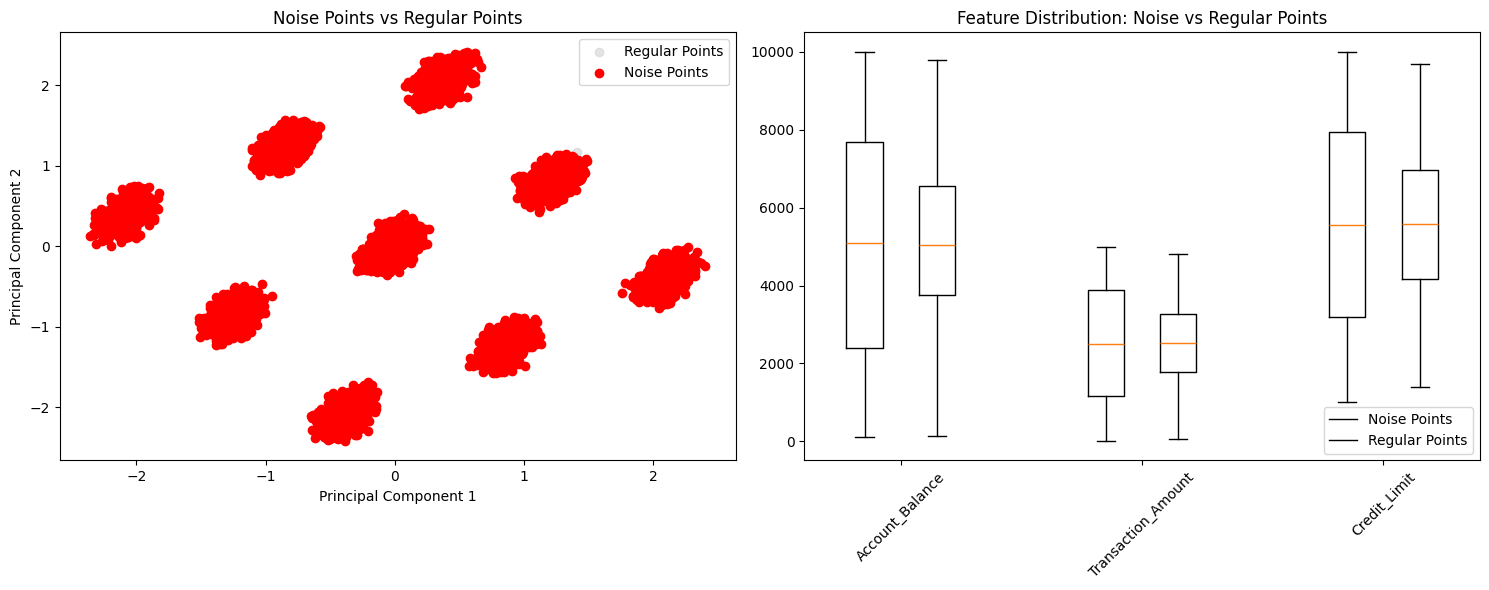


Extreme Cases in Noise Points:

Top 5 Account_Balance:
      Age  Account_Balance  Transaction_Amount  Credit_Limit
4055   46          9998.11             4979.33       9023.05
3881   32          9995.27             1837.84       2996.04
292    46          9993.05             4598.53       2961.29
370    22          9991.55              210.35       7505.92
4983   47          9988.51              998.92       8697.81

Top 5 Transaction_Amount:
      Age  Account_Balance  Transaction_Amount  Credit_Limit
4980   69          9449.20             4998.39       3264.67
2816   47          7448.69             4998.29       9185.42
1136   60           703.17             4998.12       5385.16
1417   29          3949.90             4997.52       8744.20
844    60          4877.48             4997.37       5877.22

Top 5 Credit_Limit:
      Age  Account_Balance  Transaction_Amount  Credit_Limit
699    69          3564.00             4734.38       9997.78
595    55          6227.18              67

In [38]:
# Get the best HDBSCAN configuration
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=25)
labels = clusterer.fit_predict(X_scaled)

# Create DataFrame with original features and cluster labels
df_analysis = df_encoded.copy()
df_analysis['Cluster'] = labels

# Analyze noise points
noise_points = df_analysis[df_analysis['Cluster'] == -1]
regular_points = df_analysis[df_analysis['Cluster'] != -1]

# Print summary statistics
print("Noise Points Analysis:")
print(f"Total noise points: {len(noise_points)}")
print(f"Percentage of noise points: {(len(noise_points)/len(df_analysis)*100):.2f}%\n")

# Compare noise points vs regular points
print("Feature Comparison (Mean Values):")
for feature in features:
    noise_mean = noise_points[feature].mean()
    regular_mean = regular_points[feature].mean()
    print(f"\n{feature}:")
    print(f"Noise points mean: {noise_mean:.2f}")
    print(f"Regular points mean: {regular_mean:.2f}")
    print(f"Difference: {((noise_mean/regular_mean)-1)*100:.2f}%")

# Visualize noise points characteristics
plt.figure(figsize=(15, 6))

# Plot 1: Scatter plot highlighting noise points
plt.subplot(1, 2, 1)
plt.scatter(X_pca[labels != -1, 0], X_pca[labels != -1, 1], 
           c='lightgray', label='Regular Points', alpha=0.6)
plt.scatter(X_pca[labels == -1, 0], X_pca[labels == -1, 1], 
           c='red', label='Noise Points')
plt.title('Noise Points vs Regular Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Plot 2: Box plot comparison of key features
plt.subplot(1, 2, 2)
key_features = ['Account_Balance', 'Transaction_Amount', 'Credit_Limit']
noise_data = [noise_points[feat] for feat in key_features]
regular_data = [regular_points[feat] for feat in key_features]

plt.boxplot([noise_data[i] for i in range(len(key_features))], 
           positions=np.arange(len(key_features))*2-0.3,
           labels=key_features,
           widths=0.3)
plt.boxplot([regular_data[i] for i in range(len(key_features))], 
           positions=np.arange(len(key_features))*2+0.3,
           labels=key_features,
           widths=0.3)

plt.xticks(np.arange(len(key_features))*2, key_features, rotation=45)
plt.title('Feature Distribution: Noise vs Regular Points')
plt.legend(['Noise Points', 'Regular Points'])

plt.tight_layout()
plt.show()

# Find extreme cases in noise points
print("\nExtreme Cases in Noise Points:")
for feature in ['Account_Balance', 'Transaction_Amount', 'Credit_Limit']:
    print(f"\nTop 5 {feature}:")
    print(noise_points.nlargest(5, feature)[['Age', 'Account_Balance', 
                                           'Transaction_Amount', 'Credit_Limit']])

Left Graph (Scatter Plot):

- All points shown are in red, indicating these are all noise points
- The points form distinct clusters despite being classified as noise
- The clusters are well-separated in the 2D space
- This suggests that the HDBSCAN algorithm might be too strict with its current parameters

Right Graph (Box Plot):

- Compares three key financial metrics between noise and regular points:
  1. Account_Balance: Noise points show higher variability and higher median values
  2. Transaction_Amount: Similar distribution between noise and regular points
  3. Credit_Limit: Noise points tend to have higher credit limits

In [39]:
X.sample(10)

Age  Account_Balance  Transaction_Amount  Credit_Limit  \
1501   50          9011.73              144.47       2028.39   
2586   29          3307.40             3202.17       9887.55   
2653   69          6006.41             1504.35       9037.57   
1055   59          4273.03             2202.17       4534.66   
705    20           506.61             4178.60       7685.19   
106    61          3898.95              259.59       8157.08   
589    19          6639.78             1778.33       1010.17   
2468   63          5291.63             1416.38       6211.25   
2413   26          1376.92              341.81       8494.93   
1600   39          9101.69             1122.11       1835.76   

      Credit_Card_Balance  Rewards_Points  Account_Age_Days  Gender_Male  \
1501               184.48            1670              7304        False   
2586              1190.98            9575              1616        False   
2653              4727.44            6357              7617        False   
1055              4566.86            9077               801        False   
705               1671.10            2051              2503        False   
106               4576.73            7527               749        False   
589               4773.75            1606              4934        False   
2468              3854.82            2461              7147         True   
2413              3032.19            3107              3673        False   
1600               937.23            4028              8563         True   

      Gender_Other  Account_Type_Savings  Loan_Status_Closed  \
1501         False                 False                True   
2586          True                 False               False   
2653         False                 False               False   
1055         False                  True                True   
705          False                  True               False   
106          False                  True                True   
589          False                 False               False   
2468         False                 False               False   
2413         False                  True                True   
1600         False                  True               False   

      Loan_Status_Rejected  
1501                 False  
2586                  True  
2653                 False  
1055                 False  
705                   True  
106                  False  
589                  False  
2468                  True  
2413                 False  
1600                 False

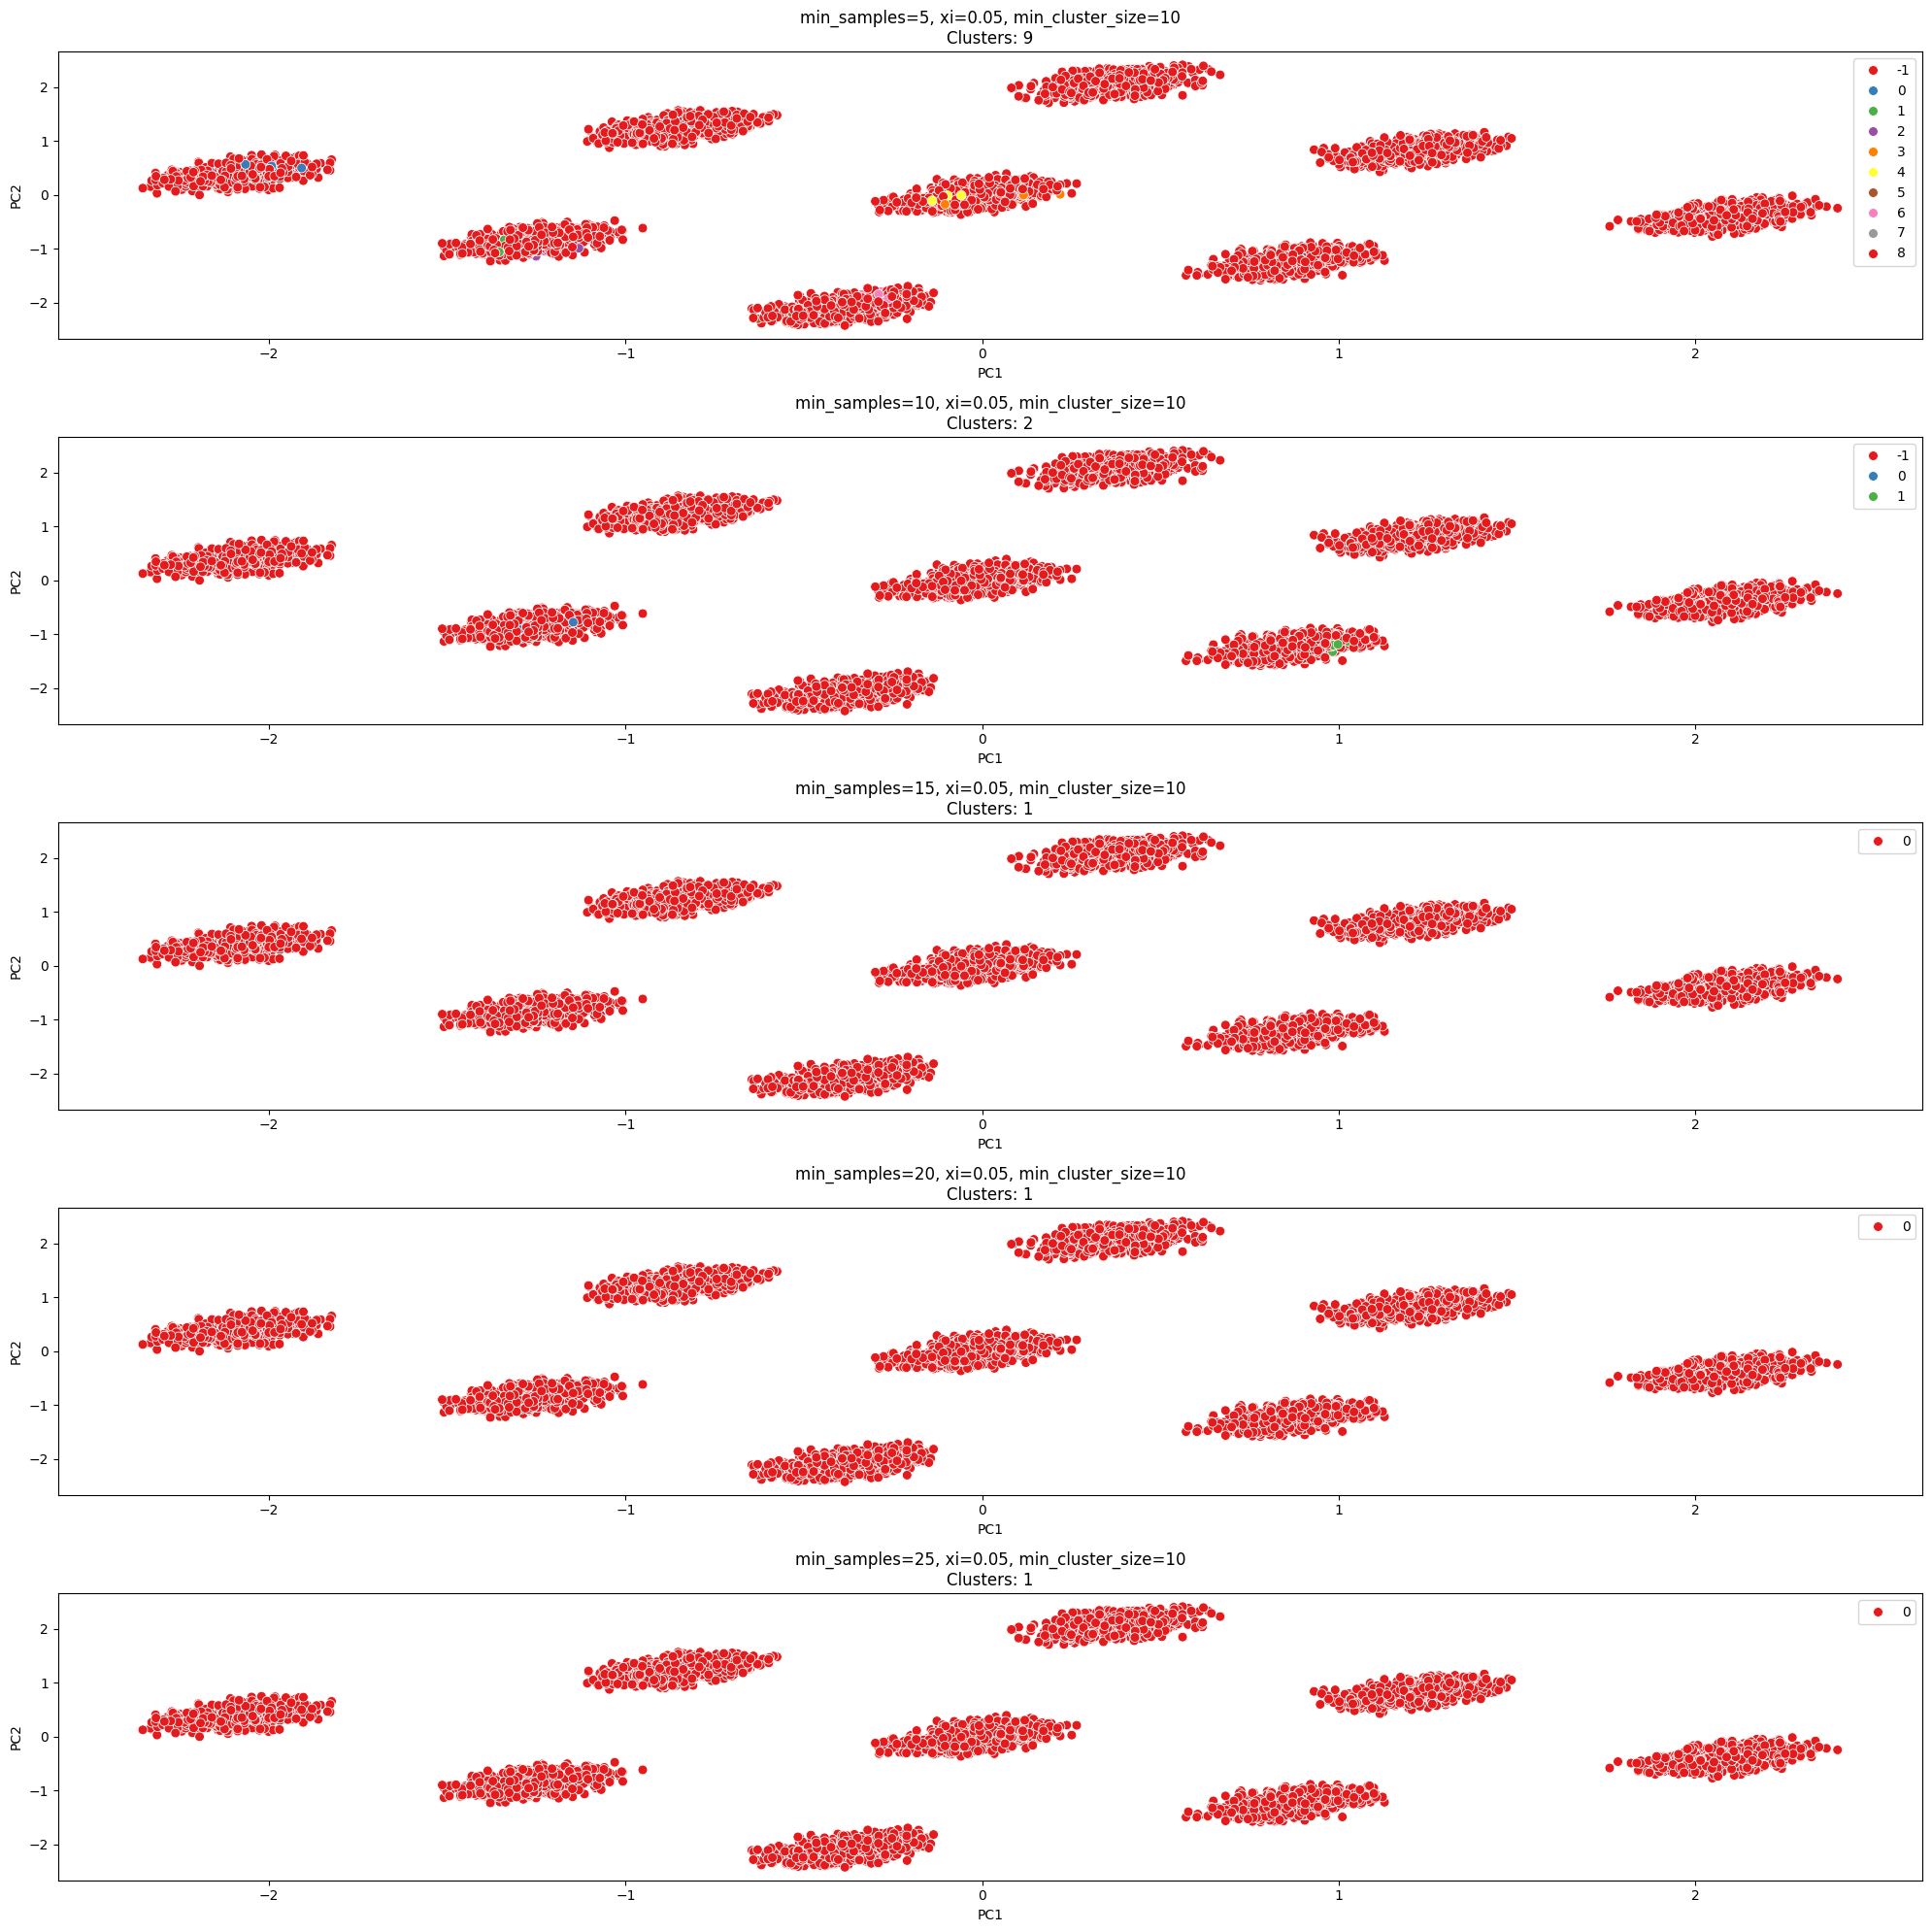


Top 5 OPTICS Configurations:
    min_samples    xi  min_cluster_size  silhouette   calinski    davies  \
15           10  0.05                10    0.602825  54.832030  0.578566   
8             5  0.15                 5    0.545467  20.222178  0.635865   
7             5  0.10                 5    0.511033  44.593168  0.683885   
14           10  0.05                 5    0.461412  39.085690  0.806495   
21           15  0.05                 5    0.446780  14.818153  0.822496   

    n_clusters  noise_points  
15           2          4978  
8            2          4989  
7           13          4924  
14          10          4924  
21           2          4986  


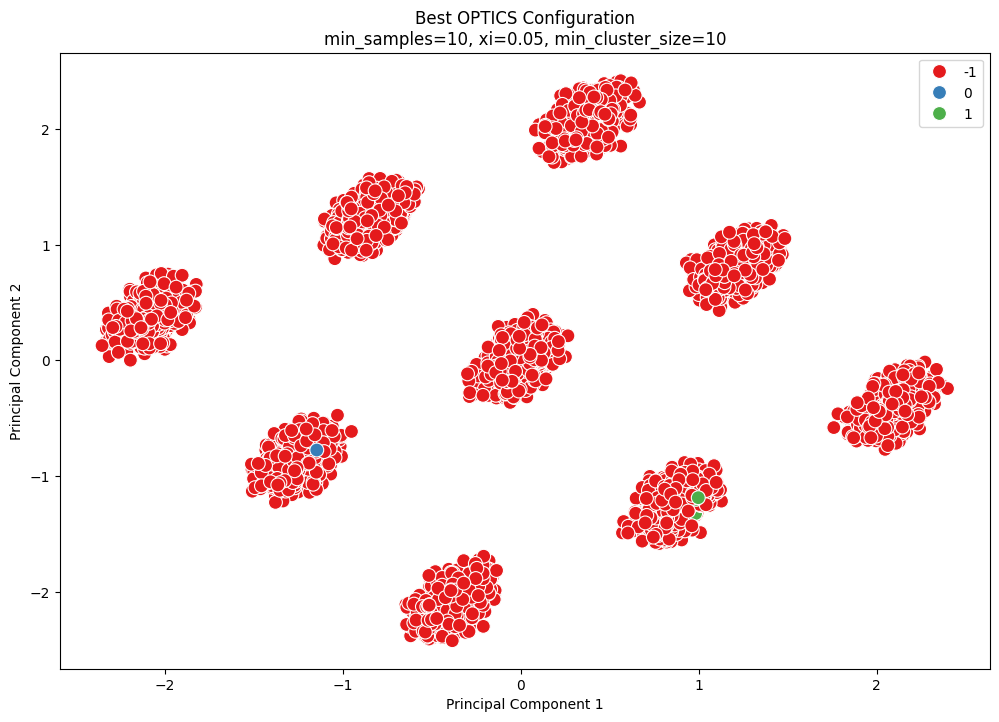


Best Configuration Metrics:
Parameters: min_samples=10, xi=0.05, min_cluster_size=10
Number of clusters: 2.0
Noise points: 4978.0
Silhouette Score: 0.603
Calinski-Harabasz Score: 54.832
Davies-Bouldin Score: 0.579

Cluster Sizes:
Cluster
-1    4978
 0      10
 1      12
Name: count, dtype: int64


In [40]:
# Test different combinations of OPTICS parameters
min_samples_range = [5, 10, 15, 20, 25]
xi_range = [0.01, 0.05, 0.1, 0.15, 0.2]
min_cluster_sizes = [5, 10, 15, 20, 25]

best_score = -1
best_params = None
best_labels = None
results = []

# Create figure for visualization
plt.figure(figsize=(20, 20))
plot_idx = 1

for min_samples in min_samples_range:
    for xi in xi_range:
        for min_cluster_size in min_cluster_sizes:
            # Fit OPTICS
            optics = OPTICS(
                min_samples=min_samples,
                xi=xi,
                min_cluster_size=min_cluster_size
            )
            labels = optics.fit_predict(X_scaled)
            
            # Calculate metrics if valid clustering exists
            valid_points = labels != -1
            if sum(valid_points) > 1 and len(set(labels)) > 1:
                X_valid = X_scaled[valid_points]
                labels_valid = labels[valid_points]
                
                if len(set(labels_valid)) > 1:
                    silhouette = silhouette_score(X_valid, labels_valid)
                    calinski = calinski_harabasz_score(X_valid, labels_valid)
                    davies = davies_bouldin_score(X_valid, labels_valid)
                    
                    results.append({
                        'min_samples': min_samples,
                        'xi': xi,
                        'min_cluster_size': min_cluster_size,
                        'silhouette': silhouette,
                        'calinski': calinski,
                        'davies': davies,
                        'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                        'noise_points': list(labels).count(-1)
                    })
                    
                    # Track best parameters based on silhouette score
                    if silhouette > best_score:
                        best_score = silhouette
                        best_params = (min_samples, xi, min_cluster_size)
                        best_labels = labels

            # Plot selected combinations
            if xi == 0.05 and min_cluster_size == 10:  # Plot only some combinations to avoid overcrowding
                plt.subplot(5, 1, min_samples_range.index(min_samples) + 1)
                sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=50)
                plt.title(f'min_samples={min_samples}, xi={xi}, min_cluster_size={min_cluster_size}\nClusters: {len(set(labels)) - (1 if -1 in labels else 0)}')
                plt.xlabel("PC1")
                plt.ylabel("PC2")

plt.tight_layout()
plt.show()

# Convert results to DataFrame and display top configurations
results_df = pd.DataFrame(results)
print("\nTop 5 OPTICS Configurations:")
print(results_df.sort_values('silhouette', ascending=False).head())

# Plot best configuration
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=best_labels, palette='Set1', s=100)
plt.title(f'Best OPTICS Configuration\nmin_samples={best_params[0]}, xi={best_params[1]}, min_cluster_size={best_params[2]}')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Print detailed metrics for best configuration
print("\nBest Configuration Metrics:")
print(f"Parameters: min_samples={best_params[0]}, xi={best_params[1]}, min_cluster_size={best_params[2]}")
best_result = results_df.loc[results_df['silhouette'].idxmax()]
print(f"Number of clusters: {best_result['n_clusters']}")
print(f"Noise points: {best_result['noise_points']}")
print(f"Silhouette Score: {best_result['silhouette']:.3f}")
print(f"Calinski-Harabasz Score: {best_result['calinski']:.3f}")
print(f"Davies-Bouldin Score: {best_result['davies']:.3f}")

# Analyze cluster characteristics for best configuration
df_analysis = df_encoded.copy()
df_analysis['Cluster'] = best_labels
print("\nCluster Sizes:")
print(df_analysis['Cluster'].value_counts().sort_index())